- Reference<br>
Medium - Multi-label Text Classification with BERT using Pytorch<br>
https://kyawkhaung.medium.com/multi-label-text-classification-with-bert-using-pytorch-47011a7313b9<br>
Kaggle - Multi Label Image Classification<br>
https://www.kaggle.com/code/boascent/multi-label-image-classification-pytorch-gpu/notebook<br>

- Import Module

In [1]:
# torch/BERT
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel, BertTokenizer

# evaluation matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# basic package
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd, random
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# check CUDA(GPU)
print('Is CUDA available ?',torch.cuda.is_available())
device = torch.device('cuda:0')

# reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Is CUDA available ? True


- Dataset

In [2]:
# read review datasets 
def READ(game_name):
    temp = pd.read_excel(f'data_cleaned\\labeled data\\{game_name}.xlsx')[:1000]
    temp['game'] = game_name
    return temp[temp.check == 1]

# combine datasets
game_list = ['Warhammer 40,000 - Darktide','Brotato','Cult of the Lamb','Teardown','Mount & Blade 2 - Bannerlord']
df_train = pd.concat([READ(game) for game in game_list])
df_train = df_train[df_train.Spam == 0] # drop spam review
df_train.drop(columns = ['Spam', 'date', 'helpful_votes', 'check'], inplace = True) # drop unneccessary column
df_train.dropna(inplace = True)

# sampe 
def SAMPLE(i, df = df_train, seed = SEED):
    tag_list = ['Not helpful','Suggestion','Pro','Con','Bug']
    return df[df[tag_list[i]]==1].sample(n = 140, random_state = seed)
df_train = pd.concat([SAMPLE(0), SAMPLE(1), SAMPLE(2), SAMPLE(3), SAMPLE(4)])
print(df_train.shape)

# label distribution of each game after ramdom sample
display(df_train.groupby(['game']).sum())

(700, 7)


,Not helpful,Suggestion,Pro,Con,Bug
game,,,,,
Brotato,27,36,37,7,7
Cult of the Lamb,25,16,39,13,22
Mount & Blade 2 - Bannerlord,45,44,23,18,12
Teardown,26,19,27,19,21
"Warhammer 40,000 - Darktide",17,25,14,83,78


- Model

In [3]:
# tokenization(return token_id and attention_mask)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
def tokenization(sentences):
    input_ids, attention_masks = [], []
    for text in sentences:        
        encoded_dict = tokenizer.encode_plus(text, add_special_tokens = True,
                                             max_length = 150, pad_to_max_length = True,
                                             return_attention_mask = True, return_tensors = 'pt')  
        input_ids.append(encoded_dict['input_ids'])     
        attention_masks.append(encoded_dict['attention_mask'])
    return torch.cat(input_ids, dim = 0).to(device), torch.cat(attention_masks, dim = 0).to(device)

In [5]:
# hyperparameters
num_epochs = 12
batch_size = 20
learning_rate = 0.0001
Labels_list = ['Not helpful','Suggestion','Pro','Con','Bug']
num_class = len(Labels_list)

# neural network
class BertClassifier(nn.Module):
    def __init__(self, num_class):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear1 = nn.Linear(self.bert.config.hidden_size, 64)
        self.linear2 = nn.Linear(64, num_class)
        self.elu = nn.ELU(inplace = True)
        
    def forward(self, ids, mask):
        output = self.bert(input_ids = ids, attention_mask = mask)
        output = self.linear1(output[1])
        return self.linear2(output)

- Model training

In [6]:
# split to training and testing
train_dataset, test_dataset = train_test_split(df_train, test_size = 0.3, random_state = SEED)
display(train_dataset.groupby(['game']).sum())

# dataloader
Input_ids, Attention_Masks = tokenization(train_dataset.review_clear.values)
Labels = torch.tensor(train_dataset[Labels_list].astype(float).values).to(device)
train_loader = DataLoader(dataset = TensorDataset(Input_ids, Attention_Masks, Labels), batch_size  = batch_size, shuffle = True)

# model, loss function and optimizer
bert = BertClassifier(num_class).to(device)
for param in bert.bert.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bert.parameters(), lr = learning_rate)

# model training
bert.train()
total_steps, loss_list = len(train_loader), []
# epoch loop
for epoch in range(num_epochs):
    clear_output(wait = True)
    epoch_loss = 0

    # batch iteration
    for step, batch in enumerate(train_loader):
        print(f'Epoch [{epoch+1}/{num_epochs}] Iteration [{step}]')
        clear_output(wait = True)
        
        # forward pass
        ids, mask, labels = batch
        output = bert(ids, mask)
        loss = criterion(output, labels)
        
        # record loss and accuaracy
        epoch_loss += loss
        
        #release memory
        del ids, mask, labels
        torch.cuda.empty_cache()
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
       
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/(step+1)}')
    loss_list.append(epoch_loss/(step+1))

Epoch [12/12], Loss: 0.05841593793686481


The smallest loss: 0.05841593793686481


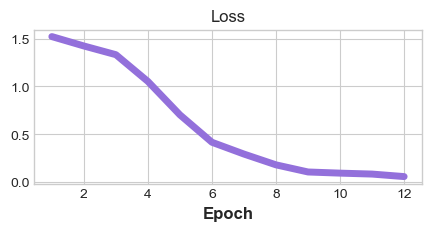

In [7]:
print(f'The smallest loss: {min(loss_list)}')
fig = plt.figure()
plt.style.use('seaborn-whitegrid') 
plt.plot(range(1,len(loss_list)+1),[float(x.cpu().detach()) for x in loss_list],c = "mediumpurple",linewidth = 5.0) 
plt.xlabel("Epoch", fontweight = "bold", fontsize = 12)                        
fig.set_size_inches(5, 2) 
plt.title('Loss')
plt.show()

- Inference

In [8]:
def CONFUSION_MATRIX(arr_true, arr_pred):
    TP, FP, FN, TN = 0, 0, 0, 0
    for i in range(arr_true.shape[0]):
        if 1 == arr_true[i] != arr_pred[i]:
            FN += 1
        elif 0 == arr_true[i] != arr_pred[i]:
            FP += 1
        elif arr_true[i]==arr_pred[i]==0:
            TN += 1
        else:
            TP += 1
    return np.array([[TP,FP],[FN,TN]])

# the validation dataset
df_valid = test_dataset[['game']+Labels_list]
display(df_valid.groupby(['game']).sum())

# dataloader
Input_ids, Attention_Masks = tokenization(test_dataset.review_clear.values)
test_loader = DataLoader(dataset = TensorDataset(Input_ids, Attention_Masks), batch_size  = batch_size)

# evaluation
bert.eval()
test_predict_list= []
softmax = nn.Softmax(dim = 1)
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        ids, mask = batch
        test_predict_list += softmax(bert(ids, mask)).cpu().detach().numpy().tolist()

mat = np.array(test_predict_list)
pred = np.zeros(mat.shape)  # our zeros and ones will go here
pred[np.arange(mat.shape[0]), np.argmax(mat, axis = 1)] = 1
actu = test_dataset[Labels_list].astype(float).values

# result
for i in range(len(Labels_list)):
    print(f"\n------ {Labels_list[i]} ------")
    print(f"Number of real/prediction: {actu[:,i].sum()} / {pred[:,i].sum()}")
    print("Accuracy:", accuracy_score(actu[:,i], pred[:,i]))
    print("Precision:", precision_score(actu[:,i], pred[:,i]))
    print("Recall:", recall_score(actu[:,i], pred[:,i]))
    print("F1 score:", f1_score(actu[:,i], pred[:,i]))
    print(CONFUSION_MATRIX(actu[:,i],pred[:,i]))

,Not helpful,Suggestion,Pro,Con,Bug
game,,,,,
Brotato,9,11,12,0,0
Cult of the Lamb,10,3,10,3,5
Mount & Blade 2 - Bannerlord,16,15,8,6,7
Teardown,11,7,6,4,6
"Warhammer 40,000 - Darktide",6,6,4,23,22



------ Not helpful ------
Number of real/prediction: 52.0 / 45.0
Accuracy: 0.8904761904761904
Precision: 0.8222222222222222
Recall: 0.7115384615384616
F1 score: 0.7628865979381444
[[ 37   8]
 [ 15 150]]

------ Suggestion ------
Number of real/prediction: 42.0 / 52.0
Accuracy: 0.8761904761904762
Precision: 0.6538461538461539
Recall: 0.8095238095238095
F1 score: 0.7234042553191489
[[ 34  18]
 [  8 150]]

------ Pro ------
Number of real/prediction: 40.0 / 37.0
Accuracy: 0.861904761904762
Precision: 0.6486486486486487
Recall: 0.6
F1 score: 0.6233766233766234
[[ 24  13]
 [ 16 157]]

------ Con ------
Number of real/prediction: 36.0 / 28.0
Accuracy: 0.8761904761904762
Precision: 0.6785714285714286
Recall: 0.5277777777777778
F1 score: 0.5937499999999999
[[ 19   9]
 [ 17 165]]

------ Bug ------
Number of real/prediction: 40.0 / 48.0
Accuracy: 0.9238095238095239
Precision: 0.75
Recall: 0.9
F1 score: 0.8181818181818182
[[ 36  12]
 [  4 158]]


The Overall Accuracy: 0.7142857142857143


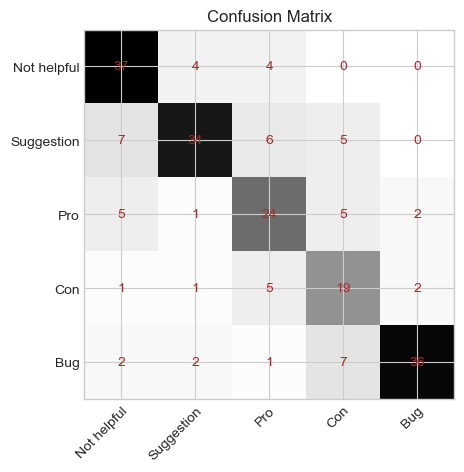

In [9]:
# Confusion Matrix
print('The Overall Accuracy: ', end = '')
print(np.trace(confusion_matrix(np.argmax(actu, axis = 1), np.argmax(mat, axis = 1)))/df_valid.shape[0])
attributes = Labels_list
df = pd.DataFrame(confusion_matrix(np.argmax(mat, axis = 1), np.argmax(actu, axis = 1)), columns=attributes, index=attributes)
fig, ax = plt.subplots()
im = ax.imshow(df)
ax.set_xticks(np.arange(len(df.columns)))
ax.set_xticklabels(df.columns)
plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
ax.set_yticks(np.arange(len(df.index)))
ax.set_yticklabels(df.index)
for i in range(len(df.columns)):
    for j in range(len(df.index)):
        text = ax.text(j, i, df.iloc[i, j], ha = "center", va = "center", color = "brown")
ax.set_title("Confusion Matrix")
plt.show()